In [1]:
# import libraries

import sys
import os
from pathlib import Path
from datetime import datetime
import time

import pandas as pd
import numpy as np
import json
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.font_manager as fm

plt.rcParams['figure.figsize'] = (25,15)
plt.rcParams['font.family'] = 'NanumGothic'

import folium
import geopandas as gpd
import fiona
from shapely.geometry import Point, LineString
import pyproj

import warnings
warnings.filterwarnings(action='ignore')

import io
from PIL import Image

import selenium

print(sys.version)

3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]


In [2]:
# 동별 인구 정보 확인 (연도별 증감 확인)
pop = pd.read_csv('data/9.부산시남구_동별_인구정보.csv', sep=',')
pop.head(5)

,age,dong,stndrd,201601,201602,201603,201604,201605,201606,201607,...,202007,202008,202009,202010,202011,202012,202101,202102,202103,202104
0,총계,남구,계,282395,281923,281549,281225,280863,280566,280326,...,270125,269626,269251,268711,268249,267731,267351,266989,265759,265194
1,총계,남구,남,139057,138808,138660,138474,138244,138067,137976,...,132209,131948,131745,131533,131310,131037,130792,130623,130080,129786
2,총계,남구,여,143338,143115,142889,142751,142619,142499,142350,...,137916,137678,137506,137178,136939,136694,136559,136366,135679,135408
3,총계,대연1동,계,21451,21476,21460,21442,21533,21560,21566,...,16138,16143,16097,16060,16001,15988,15957,15957,15940,15878
4,총계,대연1동,남,10616,10622,10631,10622,10667,10674,10675,...,8061,8065,8046,8043,8020,8017,7990,8008,8016,7989


In [3]:
pop['dong'].unique()

array(['남구', '대연1동', '대연3동', '대연4동', '대연5동', '대연6동', '용호1동', '용호2동',
       '용호3동', '용호4동', '용당동', '감만1동', '감만2동', '우암동', '문현1동', '문현2동',
       '문현3동', '문현4동'], dtype=object)

In [4]:
pop['age'].unique()

array(['총계', '0세∼4세', '0세', '1세', '2세', '3세', '4세', '5세∼9세', '5세', '6세',
       '7세', '8세', '9세', '10세∼14세', '10세', '11세', '12세', '13세', '14세',
       '15세∼19세', '15세', '16세', '17세', '18세', '19세', '20세∼24세', '20세',
       '21세', '22세', '23세', '24세', '25세∼29세', '25세', '26세', '27세', '28세',
       '29세', '30세∼34세', '30세', '31세', '32세', '33세', '34세', '35세∼39세',
       '35세', '36세', '37세', '38세', '39세', '40세∼44세', '40세', '41세', '42세',
       '43세', '44세', '45세∼49세', '45세', '46세', '47세', '48세', '49세',
       '50세∼54세', '50세', '51세', '52세', '53세', '54세', '55세∼59세', '55세',
       '56세', '57세', '58세', '59세', '60세∼64세', '60세', '61세', '62세', '63세',
       '64세', '65세∼69세', '65세', '66세', '67세', '68세', '69세', '70세∼74세',
       '70세', '71세', '72세', '73세', '74세', '75세∼79세', '75세', '76세', '77세',
       '78세', '79세', '80세∼84세', '80세', '81세', '82세', '83세', '84세',
       '85세∼89세', '85세', '86세', '87세', '88세', '89세', '90세∼94세', '90세',
       '91세', '92세', '93세', '94세', '95세∼99세', '95세', '96세', '97세', '98세

In [5]:
# 남구 및 각 동별 전체 인구만 구한다
# 운전을 할 수 있는 나이의 인구만 포함시킨다 (오토바이도 주차장에 주차할 수 있으므로  만16세 이상 인구를 포함)
# (남구 및 각 동별 전체인구) - (운전불가능 인구 = 0~16세 인구)로 구하면 될 듯
# 전체 인구 및 우선 (남구 및 각 동별 전체인구) - (운전불가능 인구)를 구한다

# 총계

is_all = (pop['age'] == '총계')
is_all_sex = (pop['stndrd'] == '계')

pop_all_age = pop[is_all&is_all_sex].reset_index(drop=True)
fin_pop_all_age = pop_all_age.drop(columns=['age', 'dong', 'stndrd'])

# 0~14세

is_no_drive1 = (pop['age'] == '0~14세')
pop_minor1 =  pop[is_no_drive1&is_all_sex].reset_index(drop=True)
fin_pop_minor1 = pop_minor1.drop(columns=['age', 'dong', 'stndrd'])

# 15세

is_no_drive2 = (pop['age'] == '15세')
pop_minor2 = pop[is_no_drive2&is_all_sex].reset_index(drop=True)
fin_pop_minor2 = pop_minor2.drop(columns=['age', 'dong', 'stndrd'])


# 16세

is_no_drive3 = (pop['age'] == '16세')
pop_minor3 = pop[is_no_drive3&is_all_sex].reset_index(drop=True)
fin_pop_minor3 = pop_minor3.drop(columns=['age', 'dong', 'stndrd'])


# 운전가능 인구 데이터프레임 만들기

pop_drive = fin_pop_all_age - (fin_pop_minor1 + fin_pop_minor2 + fin_pop_minor3)
pop_drive = pop_drive.transpose() # 분석의 용이를 위해 행과 열의 위치 변환
pop_drive = pop_drive.reset_index()

pop_drive.columns = ['date', '남구', '대연1동', '대연3동', '대연4동', '대연5동', '대연6동', '용호1동','용호2동', '용호3동', '용호4동', 
                     '용당동', '감만1동', '감만2동', '우암동', '문현1동', '문현2동','문현3동', '문현4동']# 칼럼명 변경

# 'date'를 datetime 형태로 변환

pop_drive['date']= pop_drive['date'].astype('str')
pop_drive['date'] = pop_drive['date'].apply(lambda _ : datetime.strptime(_,'%Y%m'))
pop_drive['date'] = pop_drive['date'].apply(lambda _ : datetime.strftime(_,'%Y-%m'))

pop_drive

,date,남구,대연1동,대연3동,대연4동,대연5동,대연6동,용호1동,용호2동,용호3동,용호4동,용당동,감만1동,감만2동,우암동,문현1동,문현2동,문현3동,문현4동
0,2016-01,242914,19384,29288,10034,12739,7038,36447,17040,12543,8342,7952,14246,6887,16679,14012,7853,12302,10128
1,2016-02,242593,19420,29342,10001,12761,7014,36432,16967,12523,8316,7933,14210,6880,16653,13976,7850,12214,10101
2,2016-03,242377,19425,29401,9981,12809,6978,36404,16923,12527,8316,7926,14192,6858,16626,13974,7860,12074,10103
3,2016-04,242211,19415,29371,9981,12817,6985,36379,16933,12493,8293,7925,14179,6846,16607,13965,7881,12031,10110
4,2016-05,241971,19519,29376,9968,12788,6979,36345,16895,12471,8304,7897,14174,6818,16591,13948,7874,11944,10080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2020-12,234212,14899,28021,10939,14893,12740,38022,14576,11497,7794,7173,12469,6409,12042,12489,8224,13923,8102
60,2021-01,233986,14877,27953,10953,14911,12747,38040,14595,11452,7749,7234,12408,6378,12032,12462,8194,13929,8072
61,2021-02,233789,14882,27941,10941,14968,12751,37951,14574,11422,7756,7269,12334,6348,12009,12442,8210,13939,8052
62,2021-03,232656,14864,27952,10878,14926,12698,37879,14399,11380,7707,7232,12236,6313,11882,12332,8060,13909,8009


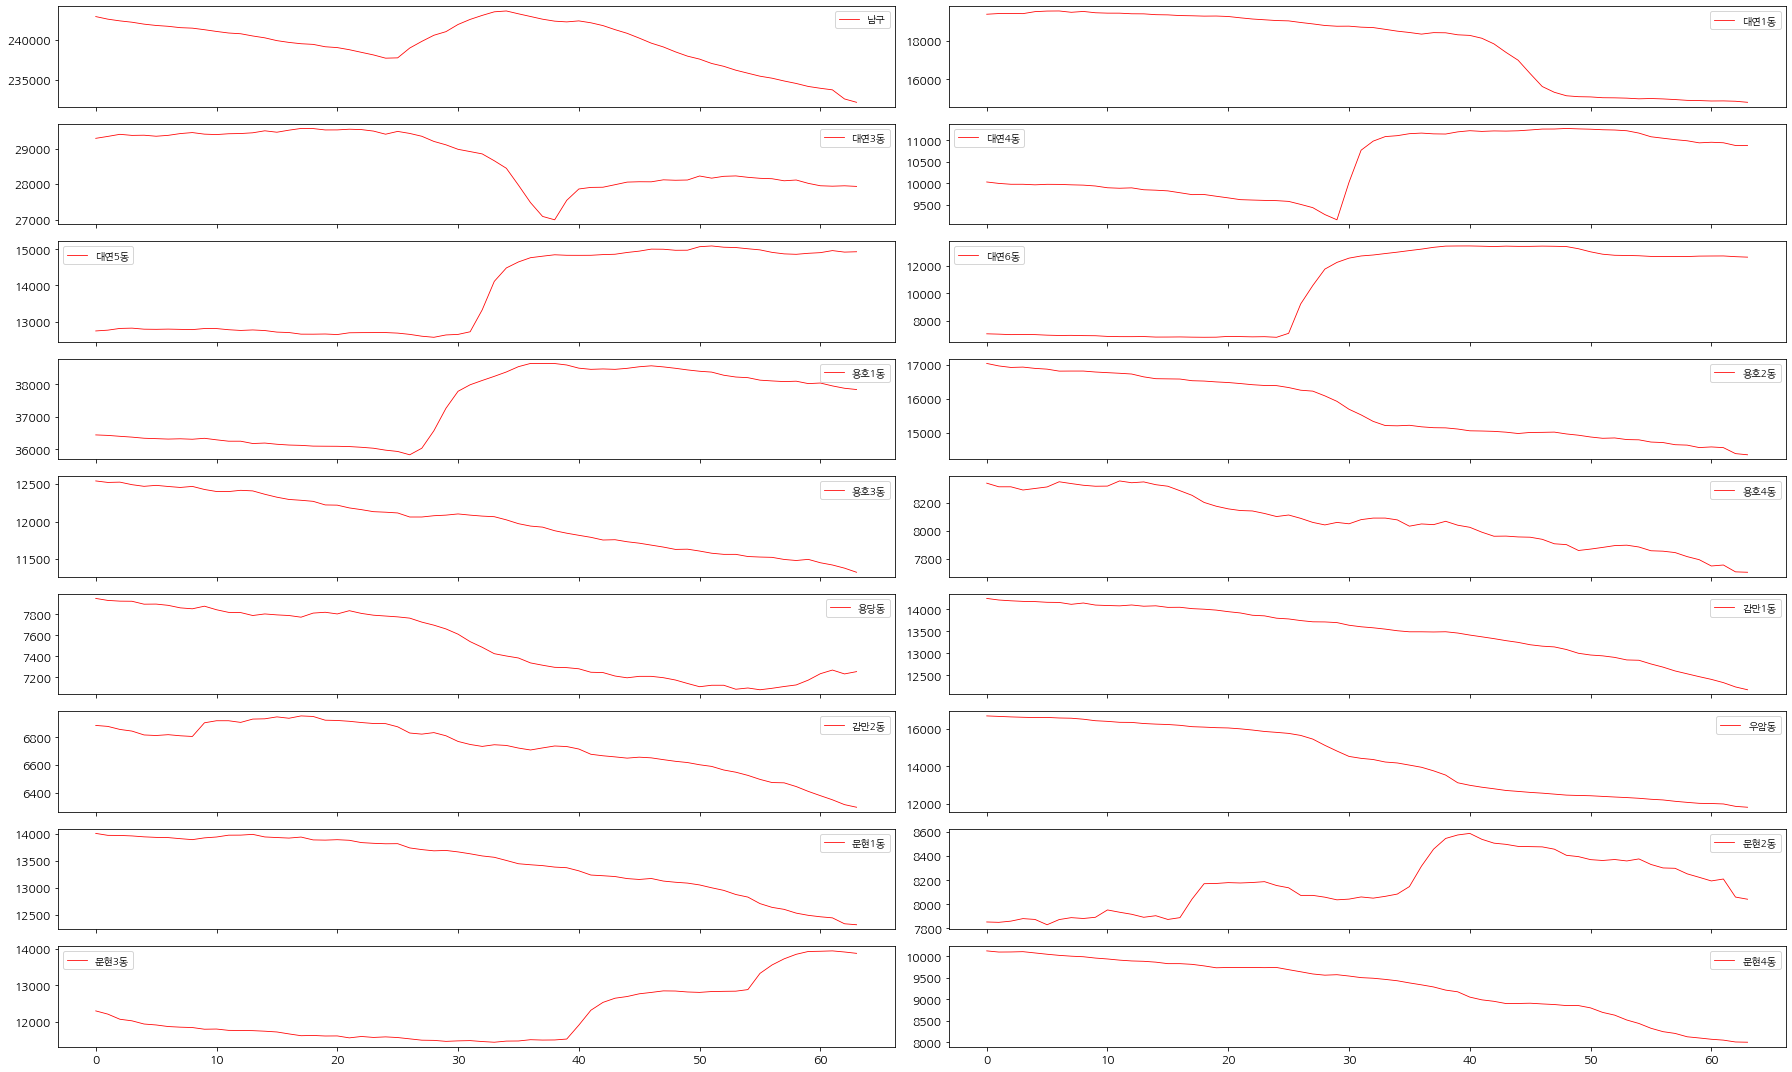

In [6]:
# 그래프로 나타내기 (인구추이)

pop_drive.plot(subplots=True,
          layout=(9,2),
          sharex=True,
          sharey=False,
          color='red',
         fontsize=12,
         legend=True,
         linewidth=0.8);
plt.tight_layout();

In [7]:
# 운전가능인구와 행정구역 매핑 (가장 최신 인구 기준 -> 2021-04)

# 행정경계 데이터 불러오기

emd = gpd.read_file('data/14.부산시남구_행정경계(읍면동).geojson')

# 2021-04 기준 인구 데이터 추출 및 데이터프레임 형태 변환

is_latest = (pop_drive['date'] == '2021-04')
pop_drive_latest = pop_drive[is_latest]
pop_drive_latest = pop_drive_latest.transpose().reset_index()
pop_drive_latest.columns = ['nm','pop']
pop_drive_latest = pop_drive_latest.drop(index=0).drop(index=1).reset_index(drop=True)
pop_drive_latest

,nm,pop
0,대연1동,14809
1,대연3동,27935
2,대연4동,10876
3,대연5동,14936
4,대연6동,12663
5,용호1동,37840
6,용호2동,14365
7,용호3동,11325
8,용호4동,7704
9,용당동,7254


In [8]:
# geometry를 기준으로 pop_drive_latest와 emd 매핑

pop_drive_latest['code'] = 0 # 새로운 칼럼 생성
for i in range(len(pop_drive_latest)):
    for j in range(len(emd)):
        if pop_drive_latest['nm'].iloc[i] == emd['ADM_DR_NM'].iloc[j]:
            pop_drive_latest['code'].iloc[i] = emd['ADM_DR_CD'].iloc[j]
            break

In [9]:
pop_drive_latest

,nm,pop,code
0,대연1동,14809,2107070
1,대연3동,27935,2107053
2,대연4동,10876,2107054
3,대연5동,14936,2107055
4,대연6동,12663,2107056
5,용호1동,37840,2107057
6,용호2동,14365,2107058
7,용호3동,11325,2107059
8,용호4동,7704,2107060
9,용당동,7254,2107061


In [10]:
# csv파일로 저장

pop_drive_latest.to_csv('data/부산시남구_인구(2021-04기준).csv', index_label=False)

In [11]:
# 지도에 나타내기

loc = [35.1300,129.100]

converted_emd = emd.to_json()

map_pop = folium.Map(location=loc, tiles='cartodbpositron', zoom_start=13)

choropleth = folium.Choropleth(geo_data=converted_emd, data=pop_drive_latest,
              columns=['code','pop'],
              key_on='feature.properties.ADM_DR_CD',
              fill_color='PuRd',
              fill_opacity = 0.3,
              line_weight = 0.3,     
              bins = 4,
              highlight=True,
              legend_name='부산 남구 동별 인구 (명)')


# popup 추가 (8/3)

choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['ADM_DR_NM'], labels=False))

choropleth.add_to(map_pop)

map_pop

In [12]:
# 지도 저장

map_pop.save("population.html")